[DEBUG] States: [(0, 'A'), (0, 'B'), (1, 'A'), (1, 'B'), ('TERMINAL', None)]
[DEBUG] Actions: {(0, 'A'): ['Click(j1)', 'Click(j2)', 'NoClick'], (0, 'B'): ['Click(j1)', 'Click(j2)', 'NoClick'], (1, 'A'): ['Click(j1)', 'Click(j2)', 'NoClick'], (1, 'B'): ['Click(j1)', 'Click(j2)', 'NoClick'], ('TERMINAL', None): []}
[DEBUG] Transitions keys: [((0, 'A'), 'Click(j1)'), ((0, 'A'), 'Click(j2)'), ((0, 'A'), 'NoClick'), ((0, 'B'), 'Click(j1)'), ((0, 'B'), 'Click(j2)'), ((0, 'B'), 'NoClick'), ((1, 'A'), 'Click(j1)'), ((1, 'A'), 'Click(j2)'), ((1, 'A'), 'NoClick'), ((1, 'B'), 'Click(j1)'), ((1, 'B'), 'Click(j2)'), ((1, 'B'), 'NoClick'), (('TERMINAL', None), None)]
[DEBUG] Non-terminal states are: [(0, 'A'), (0, 'B'), (1, 'A'), (1, 'B')]
[DEBUG] Starting trajectory 1 from state (1, 'A')
[DEBUG] Starting simulation from state: (1, 'A')
[DEBUG] Current state: (1, 'A'), Valid actions: ['Click(j1)', 'Click(j2)', 'NoClick']
[DEBUG] Chosen action: Click(j1)
[DEBUG] Next states = [(1, 'A'), ('TERMINAL', 

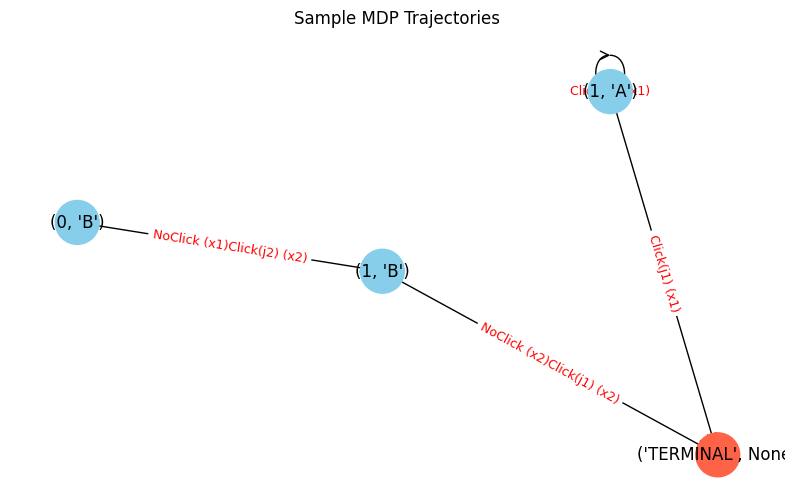

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple

# A small container for transitions: next_state and probability
Transition = namedtuple("Transition", ["next_state", "prob"])

def build_mdp():
    """
    Construct a toy MDP:
      - Two query indices: k in {0,1}
      - Two user segments: i in {'A','B'}
      - Possible actions at each (k, i): Click(j1), Click(j2), NoClick
      - Terminal state: ('TERMINAL', None)
    Returns:
      states: list of all states
      actions: dict: actions[state] -> list of possible actions
      transitions: dict: transitions[(state, action)] -> list of Transition(next_state, prob)
    """
    # Define the states
    states = [
        (0, 'A'), (0, 'B'),  # Query 0
        (1, 'A'), (1, 'B'),  # Query 1
        ('TERMINAL', None)   # Terminal
    ]
    
    # Possible actions per state
    actions = {}
    for s in states:
        if s == ('TERMINAL', None):
            actions[s] = []
        else:
            actions[s] = ['Click(j1)', 'Click(j2)', 'NoClick']
    
    # Define transitions (state, action) -> list of (next_state, prob)
    transitions = {}
    
    # (0,'A')
    transitions[((0, 'A'), 'Click(j1)')] = [
        Transition((1, 'A'), 0.7), 
        Transition(('TERMINAL', None), 0.3)
    ]
    transitions[((0, 'A'), 'Click(j2)')] = [
        Transition((1, 'A'), 0.5),
        Transition(('TERMINAL', None), 0.5)
    ]
    transitions[((0, 'A'), 'NoClick')] = [
        Transition((1, 'A'), 1.0)
    ]
    
    # (0,'B')
    transitions[((0, 'B'), 'Click(j1)')] = [
        Transition((1, 'B'), 0.8),
        Transition(('TERMINAL', None), 0.2)
    ]
    transitions[((0, 'B'), 'Click(j2)')] = [
        Transition((1, 'B'), 0.4),
        Transition(('TERMINAL', None), 0.6)
    ]
    transitions[((0, 'B'), 'NoClick')] = [
        Transition((1, 'B'), 1.0)
    ]
    
    # (1,'A')
    transitions[((1, 'A'), 'Click(j1)')] = [
        Transition((1, 'A'), 0.3),
        Transition(('TERMINAL', None), 0.7)
    ]
    transitions[((1, 'A'), 'Click(j2)')] = [
        Transition(('TERMINAL', None), 1.0)
    ]
    transitions[((1, 'A'), 'NoClick')] = [
        Transition(('TERMINAL', None), 1.0)
    ]
    
    # (1,'B')
    transitions[((1, 'B'), 'Click(j1)')] = [
        Transition((1, 'B'), 0.2),
        Transition(('TERMINAL', None), 0.8)
    ]
    transitions[((1, 'B'), 'Click(j2)')] = [
        Transition(('TERMINAL', None), 1.0)
    ]
    transitions[((1, 'B'), 'NoClick')] = [
        Transition(('TERMINAL', None), 1.0)
    ]
    
    # Terminal state has no actions
    transitions[(( 'TERMINAL', None), None)] = []
    
    return states, actions, transitions


def simulate_trajectory(states, actions, transitions, start_state=None, random_seed=None, debug=False):
    """
    Simulate a single trajectory until hitting the TERMINAL state.
    
    Args:
      states: a list of all states
      actions: dict mapping state -> list of possible actions
      transitions: dict of ((state, action) -> [Transition(next_state, prob), ...])
      start_state: optional state to start from. If None, we pick a random non-terminal.
      random_seed: optional int for reproducible randomness
      debug: bool, if True prints debugging info at each step
      
    Returns:
      A list of (state, action) pairs, with the final state in the last pair 
      if the action leads to terminal.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Pick a start state if none provided
    non_terminal_states = [s for s in states if s != ('TERMINAL', None)]
    if start_state is None:
        idx = np.random.choice(len(non_terminal_states))
        start_state = non_terminal_states[idx]
    
    if debug:
        print(f"[DEBUG] Starting simulation from state: {start_state}")
    
    traj = []
    current_state = start_state
    
    while current_state != ('TERMINAL', None):
        valid_actions = actions[current_state]
        
        if debug:
            print(f"[DEBUG] Current state: {current_state}, Valid actions: {valid_actions}")
        
        if not valid_actions:
            # No actions means we must be effectively at terminal
            if debug:
                print(f"[DEBUG] No valid actions for {current_state}, forcing termination")
            break
        
        # For demonstration, pick an action uniformly at random
        chosen_action = np.random.choice(valid_actions)
        if debug:
            print(f"[DEBUG] Chosen action: {chosen_action}")
        
        # Record (state, action)
        traj.append((current_state, chosen_action))
        
        # Weighted random transition
        possible_transitions = transitions[(current_state, chosen_action)]
        probs = [pt.prob for pt in possible_transitions]
        next_states = [pt.next_state for pt in possible_transitions]
        
        if debug:
            print(f"[DEBUG] Next states = {next_states}, probs = {probs}")
        
        chosen_idx = np.random.choice(len(next_states), p=probs)
        current_state = next_states[chosen_idx]
        
        if debug:
            print(f"[DEBUG] Transitioning to next state: {current_state}")
            print("----------------------------------------------------")
    
    return traj


def simulate_n_trajectories(n, states, actions, transitions, random_seed=None, debug=False):
    """
    Simulate n trajectories, returning a list of trajectories 
    (each trajectory is a list of (state, action) pairs).
    """
    np.random.seed(random_seed)  # For reproducibility across multiple trajectories if needed
    results = []
    
    non_terminal_states = [s for s in states if s != ('TERMINAL', None)]
    if debug:
        print("[DEBUG] Non-terminal states are:", non_terminal_states)
    
    for i in range(n):
        idx = np.random.choice(len(non_terminal_states))
        start_state = non_terminal_states[idx]
        
        if debug:
            print(f"[DEBUG] Starting trajectory {i+1} from state {start_state}")
        
        tr = simulate_trajectory(states, actions, transitions, start_state=start_state, debug=debug)
        results.append(tr)
    return results


def plot_mdp_trajectories(trajectories, debug=False):
    """
    Build a directed graph from the observed (state, action) -> next_state transitions 
    across all trajectories, then visualize it with NetworkX.
    """
    graph = nx.DiGraph()
    edge_labels = defaultdict(int)
    
    for traj in trajectories:
        for i in range(len(traj)):
            (s, a) = traj[i]
            if i < len(traj) - 1:
                next_state = traj[i+1][0]
            else:
                # If it's the last pair, let's assume it's terminal
                next_state = ('TERMINAL', None)
            
            graph.add_node(s)
            graph.add_node(next_state)
            graph.add_edge(s, next_state)
            edge_labels[(s, next_state, a)] += 1
    
    pos = nx.spring_layout(graph, seed=42)
    
    if debug:
        print("[DEBUG] Graph nodes:", list(graph.nodes()))
        print("[DEBUG] Graph edges:", list(graph.edges()))
    
    plt.figure(figsize=(10, 6))
    
    node_colors = []
    for node in graph.nodes():
        if node == ('TERMINAL', None):
            node_colors.append('tomato')
        else:
            node_colors.append('skyblue')
    
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=1000)
    nx.draw_networkx_edges(graph, pos, arrowstyle='->', arrowsize=15)
    nx.draw_networkx_labels(graph, pos, font_color='black', 
                            labels={n: str(n) for n in graph.nodes()})
    
    # Prepare edge label dictionary
    label_dict = {}
    for (s, nxt, act), count in edge_labels.items():
        current_str = label_dict.get((s, nxt), "")
        current_str += f"{act} (x{count})\n"
        label_dict[(s, nxt)] = current_str.strip()
    
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=label_dict,
                                 font_color='red', font_size=9)
    
    plt.title("Sample MDP Trajectories")
    plt.axis('off')
    plt.show()


def main(debug=False):
    # 1) Build the toy MDP
    states, actions, transitions = build_mdp()
    
    # Optional debug print
    if debug:
        print("[DEBUG] States:", states)
        print("[DEBUG] Actions:", actions)
        print("[DEBUG] Transitions keys:", list(transitions.keys()))
    
    # 2) Simulate a few trajectories
    trajs = simulate_n_trajectories(
        n=5, 
        states=states, 
        actions=actions, 
        transitions=transitions, 
        random_seed=42,
        debug=debug
    )
    
    # 3) Print out the resulting trajectories
    for idx, traj in enumerate(trajs, 1):
        print(f"Trajectory {idx}:")
        for (st, ac) in traj:
            print(f"  State: {st}, Action: {ac}")
        print()
    
    # 4) Plot the aggregated transitions
    plot_mdp_trajectories(trajs, debug=debug)


if __name__ == "__main__":
    main(debug=True)  # Set debug=True to enable debugging prints
